In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### EDA

In [2]:
housing = pd.read_csv('housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

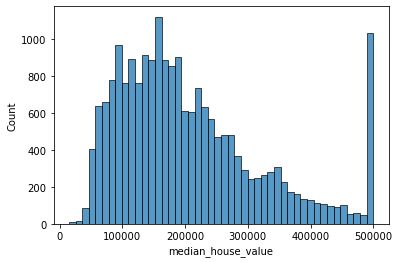

In [3]:
sns.histplot(housing['median_house_value'])

# The 'median_house_value' has a long tail

In [4]:
features = ['latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value']

In [5]:
housing_features = housing[features]
new_housing_features = housing_features.copy()
housing_features_1 = housing_features.copy()
len(housing_features_1)

20640

### Question 1

In [6]:
housing_features.isnull().sum()

# The 'total_bedroom' has missing values; 207 missing values in total

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

In [7]:
housing_features['population'].median()

# The median (50th percentile) of the 'population' column is 1166.0

1166.0

### Splitting the data

In [8]:
# Setting the random seed

np.random.seed(42)

In [9]:
# Splitting the dataset into train, test, split

length = len(housing_features)

idx = np.arange(length)

np.random.shuffle(idx)


val = int(length * 0.2)
test = int(length * 0.2)
train = length - val - test

In [10]:
# Shuffling the dataset

housing_train = housing_features.iloc[idx[:train]]
housing_val = housing_features.iloc[idx[train:train+val]]
housing_test = housing_features.iloc[idx[train+val:]]

In [11]:
# Separating the target variable from the dataset

y_train = np.log1p(housing_train['median_house_value'].values)
y_val = np.log1p(housing_val['median_house_value'].values)
y_test = np.log1p(housing_test['median_house_value'].values)


# Removing the target variable from the dataset

del housing_train['median_house_value']
del housing_val['median_house_value']
del housing_test['median_house_value']

### Question 3

In [12]:
# Method to train the linear regression model

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [13]:
# Method to train the linear regression model with regularization

def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [14]:
# Method for calculating the rmse

def rmse(y, y_pred):
    error = y_pred - y
    se = error ** 2
    mse = se.mean()
    
    return np.sqrt(mse)

#### Using the option of filling missing values with 0

In [15]:
# Making a copy of the original splitted data

housing_train_zero = housing_train.copy()
housing_val_zero = housing_val.copy()
housing_test_zero = housing_test.copy()

In [16]:
# Filling the missing value in 'total_bedroom' column with zero

housing_train_zero = housing_train_zero.fillna(0).values
housing_val_zero = housing_val_zero.fillna(0).values
housing_test_zero = housing_test_zero.fillna(0).values

In [17]:
w0, w = train_linear_regression(housing_train_zero, y_train)

In [18]:
# Using the validation dataset to evaluate the model

y_preds_zero = w0 + housing_val_zero.dot(w)

In [19]:
# RMSE for the first option

score = rmse(y_val, y_preds_zero)

round(score, 2)

0.33

#### Using the option of filling with the mean of the column

In [20]:
# Calculating the mean of the column with missing value

mean = round(housing_train['total_bedrooms'].mean(), 1)

In [21]:
# Making a copy of the original splitted data

housing_train_mean = housing_train.copy()
housing_val_mean = housing_val.copy()
housing_test_mean = housing_test.copy()

In [22]:
# Filling the missing value in 'total_bedroom' column with the mean

housing_train_mean = housing_train_mean.fillna(mean).values
housing_val_mean = housing_val_mean.fillna(mean).values
housing_test_mean = housing_test_mean.fillna(mean).values

In [23]:
w0, w = train_linear_regression(housing_train_mean, y_train)

In [24]:
# Using the validation dataset to evaluate the model

y_preds_mean = w0 + housing_val_mean.dot(w)

In [25]:
# RMSE for the second option

score = rmse(y_val, y_preds_mean)

round(score, 2)

0.33

###### Comparing the RMSE value of both option, they are both equal

### Question 4

In [26]:
r_value = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
r_score = []

In [27]:
for i in r_value:
    w0, w = train_linear_regression_reg(housing_train_zero, y_train, i)
    
    y_preds_zero = w0 + housing_val_zero.dot(w)
    
    score = round(rmse(y_val, y_preds_zero), 2)
    
    r_score.append(score)

In [28]:
r_score

# Since there are multiple options which gave the smallest 'r value', the smallest being 0 is selected

[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.34, 0.34]

### Question 5

In [29]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores_list = []

In [30]:
for i in seed_values:
    
    np.random.seed(i)
    
    # Splitting the dataset into train, test, split
    length = len(new_housing_features)

    idx = np.arange(length)

    np.random.shuffle(idx)


    val = int(length * 0.2)
    test = int(length * 0.2)
    train = length - val - test
    
    # Splitting the dataset

    new_housing_train = new_housing_features.iloc[idx[:train]]
    new_housing_val = new_housing_features.iloc[idx[train:train+val]]
    new_housing_test = new_housing_features.iloc[idx[train+val:]]
    
    # Separating the target variable from the dataset

    new_y_train = np.log1p(new_housing_train['median_house_value'].values)
    new_y_val = np.log1p(new_housing_val['median_house_value'].values)
    new_y_test = np.log1p(new_housing_test['median_house_value'].values)


    # Removing the target variable from the dataset

    del new_housing_train['median_house_value']
    del new_housing_val['median_house_value']
    del new_housing_test['median_house_value']
    
    
    # Making a copy of the splitted data

    new_housing_train_zero = new_housing_train.copy()
    new_housing_val_zero = new_housing_val.copy()
    new_housing_test_zero = new_housing_test.copy()
    
    
    # Filling the missing value in 'total_bedroom' column with zero

    new_housing_train_zero = new_housing_train_zero.fillna(0).values
    new_housing_val_zero = new_housing_val_zero.fillna(0).values
    new_housing_test_zero = new_housing_test_zero.fillna(0).values
    
    
    # Training the linear regression model
    w0, w = train_linear_regression(new_housing_train_zero, new_y_train)
    
    # Using the validation dataset to evaluate the model

    y_preds_zero = w0 + new_housing_val_zero.dot(w)
    
    
    # Finding the RMSE
    score = round(rmse(new_y_val, y_preds_zero), 2)
    
    scores_list.append(score)

In [31]:
scores_list

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]

In [32]:
round(np.std(scores_list), 3)

# The Standard deviation of the scores is 0.005

0.005

### Question 6

In [33]:
np.random.seed(9)

In [34]:
# Splitting the dataset into train, test, split
length = len(housing_features_1)

idx = np.arange(length)

np.random.shuffle(idx)


val = int(length * 0.2)
test = int(length * 0.2)
train = length - val - test
    
# Splitting the dataset

housing_train_1 = housing_features_1.iloc[idx[:train]]
housing_val_1 = housing_features_1.iloc[idx[train:train+val]]
housing_test_1 = housing_features_1.iloc[idx[train+val:]]

# Combining the train and validation datasets
housing_train_val = pd.concat([housing_train_1, housing_val_1])


# Separating the target variable from the dataset
new_y_train_val = np.log1p(housing_train_val['median_house_value'].values)
new_y_test = np.log1p(housing_test_1['median_house_value'].values)

# Removing the target variable from the dataset
del housing_train_val['median_house_value']
del housing_test_1['median_house_value']
    
    
# Making a copy of the splitted data

new_housing_train_val = housing_train_val.copy()
new_housing_test_zero = housing_test_1.copy()
    
    
# Filling the missing value in 'total_bedroom' column with zero

new_housing_train_val = new_housing_train_val.fillna(0).values
new_housing_test_zero = new_housing_test_zero.fillna(0).values

In [35]:
# Training the linear regression model
w0, w = train_linear_regression_reg(new_housing_train_val, new_y_train_val, 0.001)

In [36]:
# Using the test dataset to evaluate the model

y_preds_zero = w0 + new_housing_test_zero.dot(w)

# Finding the RMSE
score = round(rmse(new_y_test, y_preds_zero), 2)



In [37]:
score

0.35